# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #4

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [1]:
import tempfile
from copy import deepcopy

from code_analysis import CFG, ASTReader, CFGReader, Graph
from dataflow import (
    PossibleReachableReferences,
    PossiblyReachingDefinitions,
    get_key,
    is_definition,
    yield_all_vars,
)
from graphviz import Source
from IPython.display import Image


def show_graph(graph: Graph):
    """Afficher le graphe dans Jupyter"""
    dot = graph.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        display(Image(f.name + ".png"))


def show_in_out(
    cfg: CFG, in_dict: dict[int, set[int]], out_dict: dict[int, set[int]]
) -> CFG:
    """Annote un CFG avec les valeurs de in et out pour chaque noeud puis l'affiche"""
    cfg_copy = deepcopy(cfg)
    for nid in cfg_copy.get_node_ids():
        cfg_copy.set_image(
            nid,
            f"in={[cfg.get_image(v) for v in in_dict[nid]]}\n"
            f"out={[cfg.get_image(v) for v in out_dict[nid]]}\n"
            f"{cfg_copy.get_image(nid) or ''}",
        )
    show_graph(cfg_copy)
    return cfg_copy


ast_reader = ASTReader()
cfg_reader = CFGReader()

defs_dataflow = PossiblyReachingDefinitions()
refs_dataflow = PossibleReachableReferences()

## Extraction du DataFlow

In [2]:
def generate_def_ref_chain_v1(cfg: CFG):
    reaching_defs_in, _ = defs_dataflow(cfg)
    pairs: list[tuple[int, int]] = []
    for var_nid in yield_all_vars(cfg):
        if not is_definition(cfg, var_nid):
            for def_nid in reaching_defs_in[var_nid]:
                if get_key(cfg, def_nid) == get_key(cfg, var_nid):
                    pairs.append((def_nid, var_nid))
    return pairs


def generate_def_ref_chain_v2(cfg: CFG):
    _, reachable_refs_out = refs_dataflow(cfg)
    pairs: list[tuple[int, int]] = []
    for var_nid in yield_all_vars(cfg):
        if is_definition(cfg, var_nid):
            for ref_nid in reachable_refs_out[var_nid]:
                if get_key(cfg, ref_nid) == get_key(cfg, var_nid):
                    pairs.append((var_nid, ref_nid))
    return pairs


def generate_chains(cfg: CFG):
    def_ref_chain_1 = generate_def_ref_chain_v1(cfg)
    def_ref_chain_2 = generate_def_ref_chain_v2(cfg)

    for def_id, ref_id in def_ref_chain_1:
        print(
            f"{cfg.get_image(def_id)} (ligne {cfg.get_position(def_id)[0]}) "
            f"référencé à la ligne {cfg.get_position(ref_id)[0]}"
        )

    for ref_id, def_id in def_ref_chain_2:
        print(
            f"{cfg.get_image(ref_id)} (ligne {cfg.get_position(ref_id)[0]}) "
            f"définie à la ligne {cfg.get_position(def_id)[0]}"
        )

    return def_ref_chain_1, def_ref_chain_2

In [3]:
cfg = cfg_reader.read_cfg("../tp4/part_1/test.php.cfg.json")

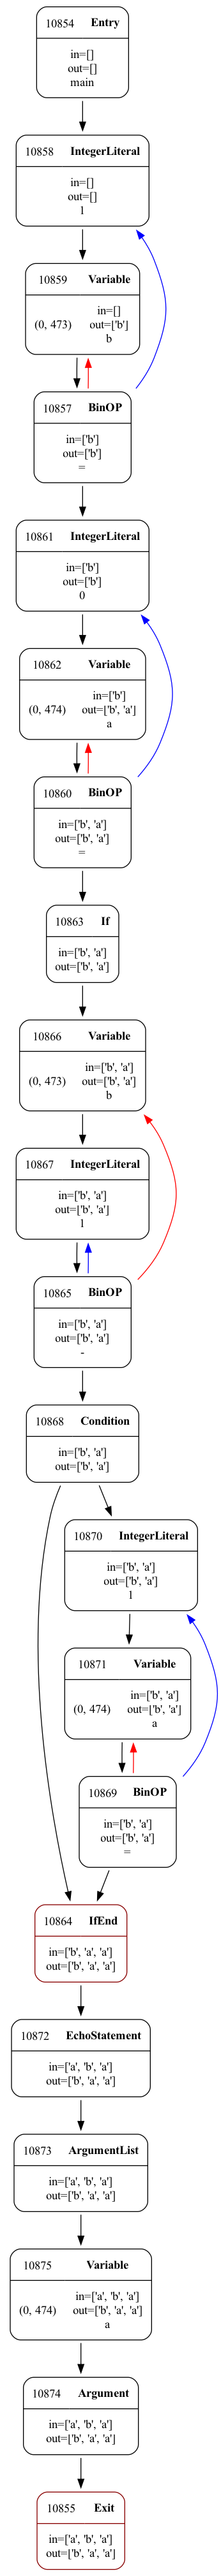

In [4]:
in_dict, out_dict = defs_dataflow(cfg)
show_in_out(cfg, in_dict, out_dict)

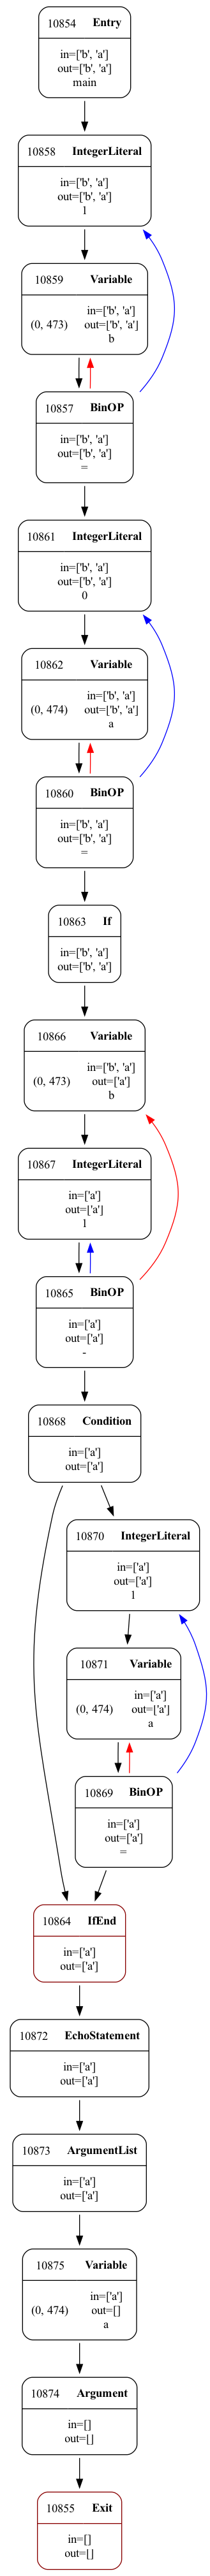

In [5]:
in_dict, out_dict = refs_dataflow(cfg)
show_in_out(cfg, in_dict, out_dict)

In [6]:
def_ref_chain_1, def_ref_chain_2 = generate_chains(cfg)
print(def_ref_chain_1)
print(def_ref_chain_2)

b (ligne 2) référencé à la ligne 5
a (ligne 6) référencé à la ligne 8
a (ligne 3) référencé à la ligne 8
b (ligne 2) définie à la ligne 5
a (ligne 3) définie à la ligne 8
a (ligne 6) définie à la ligne 8
[(10859, 10866), (10871, 10875), (10862, 10875)]
[(10859, 10866), (10862, 10875), (10871, 10875)]


In [22]:
cfg = cfg_reader.read_cfg("../tp4/part_1/wordcount.php.cfg.json")

In [8]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [9]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [10]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

c (ligne 19) référencé à la ligne 17
c (ligne 20) référencé à la ligne 17
c (ligne 21) référencé à la ligne 17
c (ligne 29) référencé à la ligne 17
c (ligne 29) référencé à la ligne 17
c (ligne 29) référencé à la ligne 17
c (ligne 15) référencé à la ligne 17
nl (ligne 18) référencé à la ligne 18
nl (ligne 8) référencé à la ligne 18
nl (ligne 18) référencé à la ligne 18
c (ligne 17) référencé à la ligne 19
c (ligne 20) référencé à la ligne 19
c (ligne 21) référencé à la ligne 19
c (ligne 29) référencé à la ligne 19
c (ligne 29) référencé à la ligne 19
c (ligne 29) référencé à la ligne 19
c (ligne 15) référencé à la ligne 19
c (ligne 17) référencé à la ligne 20
c (ligne 19) référencé à la ligne 20
c (ligne 21) référencé à la ligne 20
c (ligne 29) référencé à la ligne 20
c (ligne 29) référencé à la ligne 20
c (ligne 29) référencé à la ligne 20
c (ligne 15) référencé à la ligne 20
c (ligne 17) référencé à la ligne 21
c (ligne 19) référencé à la ligne 21
c (ligne 20) référencé à la ligne 21

## Variable vive/morte

In [11]:



def print_ref_not_def(cfg: CFG, def_ref_chain: list[tuple[int, int]]):
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable" and not is_definition(cfg, nid):
            for def_ref in def_ref_chain:
                if def_ref[1] == nid:
                    break
            else:
                print(
                    f"Variable {cfg.get_image(nid)} (ligne {cfg.get_position(nid)[0]}) n'est pas définie"
                )


def print_def_not_ref(cfg: CFG, ref_def_chain: list[tuple[int, int]]):
    for nid in cfg.get_node_ids():
        if cfg.get_type(nid) == "Variable" and is_definition(cfg, nid):
            for ref_def in ref_def_chain:
                if ref_def[0] == nid:
                    break
            else:
                print(
                    f"Variable {cfg.get_image(nid)} (ligne {cfg.get_position(nid)[0]}) n'est pas référencée"
                )

## Partie 2 > Test avec la partie 1

In [12]:
cfg = cfg_reader.read_cfg("../tp4/part_1/test.php.cfg.json")
def_ref_chain, ref_def_chain = generate_chains(cfg)
print(def_ref_chain)
print(ref_def_chain)

b (ligne 2) référencé à la ligne 5
a (ligne 3) référencé à la ligne 6
a (ligne 6) référencé à la ligne 8
a (ligne 3) référencé à la ligne 8
b (ligne 2) définie à la ligne 5
a (ligne 3) définie à la ligne 8
a (ligne 6) définie à la ligne 8
[(10859, 10866), (10862, 10871), (10871, 10875), (10862, 10875)]
[(10859, 10866), (10862, 10875), (10871, 10875)]


In [13]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

## Partie 2 > File1

In [14]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file1.php.cfg.json")

In [15]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [16]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [17]:
def_ref_chain, ref_def_chain = generate_chains(cfg)
print(def_ref_chain)
print(ref_def_chain)

out (ligne 9) référencé à la ligne 9
out (ligne 5) référencé à la ligne 9
line (ligne 8) référencé à la ligne 9
out (ligne 9) référencé à la ligne 9
filename (ligne 3) référencé à la ligne 4
fp (ligne 7) référencé à la ligne 10
line (ligne 9) référencé à la ligne 10
line (ligne 8) référencé à la ligne 10
fp (ligne 10) référencé à la ligne 13
fp (ligne 7) référencé à la ligne 13
fp (ligne 4) référencé à la ligne 7
out (ligne 9) référencé à la ligne 15
out (ligne 9) référencé à la ligne 15
out (ligne 5) référencé à la ligne 15
fp (ligne 10) référencé à la ligne 14
fp (ligne 13) référencé à la ligne 14
fp (ligne 7) référencé à la ligne 14
line (ligne 9) référencé à la ligne 8
line (ligne 10) référencé à la ligne 8
line (ligne 7) référencé à la ligne 8
filename (ligne 3) définie à la ligne 4
out (ligne 9) définie à la ligne 15
line (ligne 9) définie à la ligne 8
out (ligne 9) définie à la ligne 9
out (ligne 9) définie à la ligne 15
fp (ligne 4) définie à la ligne 10
fp (ligne 4) définie à 

In [18]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable fp (ligne 14) n'est pas référencée


## Partie 2 > File2

In [19]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file2.php.cfg.json")

In [20]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [21]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [22]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

meta_type (ligne 3) référencé à la ligne 14
meta_type (ligne 4) référencé à la ligne 14
meta_type (ligne 12) référencé à la ligne 14
object_id (ligne 3) référencé à la ligne 14
object_id (ligne 4) référencé à la ligne 14
object_id (ligne 8) référencé à la ligne 14
object_id (ligne 9) référencé à la ligne 14
object_id (ligne 12) référencé à la ligne 14
meta_cache (ligne 13) référencé à la ligne 14
meta_key (ligne 3) référencé à la ligne 16
meta_cache (ligne 14) référencé à la ligne 17
meta_cache (ligne 13) référencé à la ligne 17
meta_type (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 4
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 4) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 8
object_id (ligne 3) référencé à la ligne 8
object_id (ligne 4) référencé à la ligne 8
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 3) référencé à la ligne 9
object_id (ligne 8) référencé à la ligne 9
object_id (ligne 4) référencé à la 

In [23]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable simgle (ligne 19) n'est pas définie
Variable single (ligne 3) n'est pas référencée


## Partie 2 > File3

In [24]:
cfg = cfg_reader.read_cfg("../tp4/part_2/file3.php.cfg.json")

In [25]:
in_dict, out_dict = defs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [26]:
in_dict, out_dict = refs_dataflow(cfg)
# show_in_out(cfg, in_dict, out_dict)

In [27]:
def_ref_chain, ref_def_chain = generate_chains(cfg)

regex (ligne 3282) référencé à la ligne 3272
regex (ligne 3289) référencé à la ligne 3272
regex (ligne 3293) référencé à la ligne 3272
charset (ligne 3237) référencé à la ligne 3281
charset (ligne 3249) référencé à la ligne 3281
charset (ligne 3271) référencé à la ligne 3281
charset (ligne 3271) référencé à la ligne 3281
charset (ligne 3271) référencé à la ligne 3281
regex (ligne 3272) référencé à la ligne 3282
regex (ligne 3289) référencé à la ligne 3282
regex (ligne 3293) référencé à la ligne 3282
regex (ligne 3272) référencé à la ligne 3289
regex (ligne 3282) référencé à la ligne 3289
regex (ligne 3293) référencé à la ligne 3289
regex (ligne 3282) référencé à la ligne 3293
regex (ligne 3289) référencé à la ligne 3293
value (ligne 3293) référencé à la ligne 3293
value (ligne 3295) référencé à la ligne 3293
value (ligne 3296) référencé à la ligne 3293
value (ligne 3223) référencé à la ligne 3293
value (ligne 3296) référencé à la ligne 3293
value (ligne 3224) référencé à la ligne 3293


In [28]:
print_ref_not_def(cfg, def_ref_chain)
print_def_not_ref(cfg, ref_def_chain)

Variable show_errors (ligne 65) n'est pas définie
Variable suppress_errors (ligne 74) n'est pas définie
Variable last_error (ligne 83) n'est pas définie
Variable num_queries (ligne 92) n'est pas définie
Variable num_rows (ligne 101) n'est pas définie
Variable rows_affected (ligne 110) n'est pas définie
Variable insert_id (ligne 119) n'est pas définie
Variable last_query (ligne 128) n'est pas définie
Variable last_result (ligne 137) n'est pas définie
Variable result (ligne 155) n'est pas définie
Variable col_meta (ligne 164) n'est pas définie
Variable table_charset (ligne 173) n'est pas définie
Variable check_current_query (ligne 182) n'est pas définie
Variable checking_collation (ligne 192) n'est pas définie
Variable col_info (ligne 201) n'est pas définie
Variable queries (ligne 225) n'est pas définie
Variable reconnect_retries (ligne 235) n'est pas définie
Variable prefix (ligne 247) n'est pas définie
Variable base_prefix (ligne 256) n'est pas définie
Variable ready (ligne 265) n'est 

## Filtration des données utilisateur

In [29]:
ast = ast_reader.read_ast("../tp4/part_3/file.php.ast.json")
cfg = cfg_reader.read_cfg("../tp4/part_3/file.php.cfg.json")

In [30]:
pairs = generate_def_ref_chain(cfg)


def ensure_filtered(cfg: CFG, nid: int):
    ast_nid = cfg.get_node_ast_ptr(nid)
    parent = ast.get_parents(ast_nid)[0]
    argument_list = ast.get_children(parent)[1]
    arguments = ast.get_children(argument_list)
    print(f"Arguments: {arguments}")

    for ast_arg in arguments[:-1]:
        cfg_nid = cfg.get_node_cfg_ptr(ast_arg)
        child = cfg.get_children(cfg_nid)[0]

        print(f"Checking {cfg.get_image(child)} at line {cfg.get_position(child)[0]}")

        # Search the definitions
        for pair in pairs:
            if pair[1] == child:
                definition = pair[0]
                print(
                    f"  Found definition for {cfg.get_image(child)} at line {cfg.get_position(definition)[0]}"
                )

                # Check if the definition is filtered
                var_nid = cfg.get_node_ast_ptr(definition)
                parent = ast.get_parents(var_nid)[0]
                if ast.get_type(parent) != "BinOP":
                    continue

                child = ast.get_children(parent)[1]

                if (
                    ast.get_type(child) == "FunctionCall"
                    and ast.get_image(child) == "filter_var"
                ):
                    print(
                        f"    => Filtered definition for {ast.get_image(child)} at line {cfg.get_position(definition)[0]}"
                    )
                else:
                    print(
                        f"    => Definition for {ast.get_image(child)} at line {cfg.get_position(definition)[0]} is not filtered"
                    )


for nid in cfg.get_node_ids():
    if cfg.get_image(nid) == "prepare_query":
        if not cfg.get_parents(nid):
            continue
        if cfg.get_type(cfg.get_parents(nid)[0]) != "MethodCall":
            continue

        print(f"Verifying {cfg.get_image(nid)} at line {cfg.get_position(nid)[0]}")
        ensure_filtered(cfg, nid)
        print()

Verifying prepare_query at line 741
Arguments: [9680, 9681, 9682]
Checking password at line 741
  Found definition for password at line 739
    => Filtered definition for filter_var at line 739
Checking user_id at line 741
  Found definition for user_id at line 737
  Found definition for user_id at line 738
  Found definition for user_id at line 738
    => Filtered definition for filter_var at line 738

Verifying prepare_query at line 753
Arguments: [9748, 9749, 9750]
Checking mail at line 753
  Found definition for mail at line 749
    => Filtered definition for filter_var at line 749
Checking user_id at line 753
  Found definition for user_id at line 747
  Found definition for user_id at line 750
  Found definition for user_id at line 750
    => Filtered definition for filter_var at line 750

Verifying prepare_query at line 762
Arguments: [9804, 9805, 9806]
Checking username at line 762
  Found definition for username at line 757
  Found definition for username at line 760
    => Fil